# **Importing required libraries**

In [451]:
#Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [452]:
#!pip install --upgrade tensorflow
#!pip install --upgrade keras

!pip install keras==2.12.0
!pip install tensorflow==2.12.0


In [453]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import keras
print("Keras version:", keras.__version__)



TensorFlow version: 2.12.0
Keras version: 2.12.0


# Loading the data

In [454]:
#Loading the data
df = pd.read_csv('/S&P.csv')
new_d=df.copy()
df = df.iloc[::-1]

df = df.reset_index(drop=True)
print(df)

             Date         Open         High          Low        Close  \
0      1957-03-04    44.060001    44.060001    44.060001    44.060001   
1      1957-03-05    44.220001    44.220001    44.220001    44.220001   
2      1957-03-06    44.230000    44.230000    44.230000    44.230000   
3      1957-03-07    44.209999    44.209999    44.209999    44.209999   
4      1957-03-08    44.070000    44.070000    44.070000    44.070000   
...           ...          ...          ...          ...          ...   
15115  2017-03-20  2378.239990  2379.550049  2369.659912  2373.469971   
15116  2017-03-21  2379.320068  2381.929932  2341.899902  2344.020020   
15117  2017-03-22  2343.000000  2351.810059  2336.449951  2348.449951   
15118  2017-03-23  2345.969971  2358.919922  2342.129883  2345.959961   
15119  2017-03-24  2350.419922  2356.219971  2335.739990  2343.979980   

           Volume    Adj Close  
0         1890000    44.060001  
1         1860000    44.220001  
2         1840000    44.

In [455]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       15120 non-null  object 
 1   Open       15120 non-null  float64
 2   High       15120 non-null  float64
 3   Low        15120 non-null  float64
 4   Close      15120 non-null  float64
 5   Volume     15120 non-null  int64  
 6   Adj Close  15120 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 827.0+ KB


Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [456]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [457]:
# Define the function df_to_windowed_df here
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = pd.to_datetime(first_date_str)
    last_date = pd.to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y, volumes = [], [], []

    while target_date <= last_date:
        if target_date in dataframe.index:
            df_subset = dataframe.loc[:target_date].tail(n+1)

            if len(df_subset) == n+1:
                values = df_subset[['Close', 'Volume']].to_numpy()
                x, y, volume = values[:-1, 0], values[-1, 0], values[-1, 1]

                dates.append(target_date)
                X.append(x)
                Y.append(y)
                volumes.append(volume)

        # Move to the next date
        target_date += datetime.timedelta(days=1)

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Volume'] = volumes
    ret_df['Target'] = Y

    return ret_df


# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
data = df.set_index('Date')

# Use the df_to_windowed_df function after preparing the data
windowed_df = df_to_windowed_df(data, '2002-02-21', '2012-10-23', n=3)

print(windowed_df)


     Target Date     Target-3     Target-2     Target-1        Volume  \
0     2002-02-21  1104.180054  1083.339966  1097.979980  1.381600e+09   
1     2002-02-22  1083.339966  1097.979980  1080.949951  1.411000e+09   
2     2002-02-25  1097.979980  1080.949951  1089.839966  1.367400e+09   
3     2002-02-26  1080.949951  1089.839966  1109.430054  1.309200e+09   
4     2002-02-27  1089.839966  1109.430054  1109.380005  1.393800e+09   
...          ...          ...          ...          ...           ...   
2685  2012-10-17  1428.589966  1440.130005  1454.920044  3.655320e+09   
2686  2012-10-18  1440.130005  1454.920044  1460.910034  3.880030e+09   
2687  2012-10-19  1454.920044  1460.910034  1457.339966  3.875170e+09   
2688  2012-10-22  1460.910034  1457.339966  1433.189941  3.216220e+09   
2689  2012-10-23  1457.339966  1433.189941  1433.819946  3.587670e+09   

           Target  
0     1080.949951  
1     1089.839966  
2     1109.430054  
3     1109.380005  
4     1109.890015  
...

# MODEL 01

**Scalling**

In [458]:
from sklearn.preprocessing import MinMaxScaler


columns_to_scale = ['Target-3', 'Target-2', 'Target-1', 'Target','Volume']

# Create a MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale only the numerical columns
numerical_data = windowed_df[columns_to_scale]
scaled_data = scaler.fit_transform(numerical_data)

windowed_df[columns_to_scale] = scaled_data

print(windowed_df)

     Target Date  Target-3  Target-2  Target-1    Volume    Target
0     2002-02-21  0.481252  0.457800  0.474275  0.092389  0.455110
1     2002-02-22  0.457800  0.474275  0.455110  0.095037  0.465114
2     2002-02-25  0.474275  0.455110  0.465114  0.091109  0.487160
3     2002-02-26  0.455110  0.465114  0.487160  0.085866  0.487104
4     2002-02-27  0.465114  0.487160  0.487104  0.093488  0.487678
...          ...       ...       ...       ...       ...       ...
2685  2012-10-17  0.846323  0.859310  0.875954  0.297225  0.882695
2686  2012-10-18  0.859310  0.875954  0.882695  0.317469  0.878677
2687  2012-10-19  0.875954  0.882695  0.878677  0.317031  0.851500
2688  2012-10-22  0.882695  0.878677  0.851500  0.257667  0.852209
2689  2012-10-23  0.878677  0.851500  0.852209  0.291131  0.828903

[2690 rows x 6 columns]


In [459]:
#windowed_df.index = windowed_df.pop('Target Date')
#windowed_df

Target natural graph

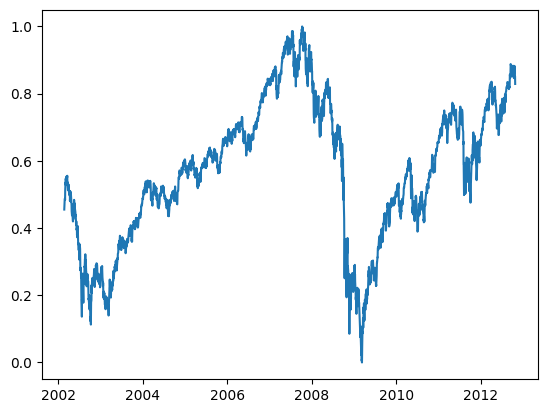

In [460]:
plt.plot(windowed_df['Target Date'],windowed_df['Target'])

Extracting "Date" , "Inputs(features)" and , "Output(target)"

In [461]:
# Convert the DataFrame to a NumPy array
df_as_np = windowed_df.to_numpy()



# Extract dates from the first column
dates = df_as_np[:,0]


# Extract the feature matrix from columns 1 to second-to-last column
middle_matrix = df_as_np[:, 1:-1]

# Reshape the feature matrix
X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

# Extract the target values from the last column
Y = df_as_np[:, -1]


X = X.astype(np.float32)
y = Y.astype(np.float32)

# Print the shapes of the arrays
print("Dates shape:", dates.shape)
print("X shape:", X.shape)
print("Y shape:", Y.shape)



Dates shape: (2690,)
X shape: (2690, 4, 1)
Y shape: (2690,)


Splitting into train , test and validator

In [462]:
q_80 = int(len(dates)* .8)
q_90 = int(len(dates)* .9)

dates_train, X_train, y_train = dates[:q_80],X[:q_80],y[:q_80]


dates_val, X_val, y_val = dates[q_80:q_90],X[q_80:q_90],y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:],X[q_90:],y[q_90:]

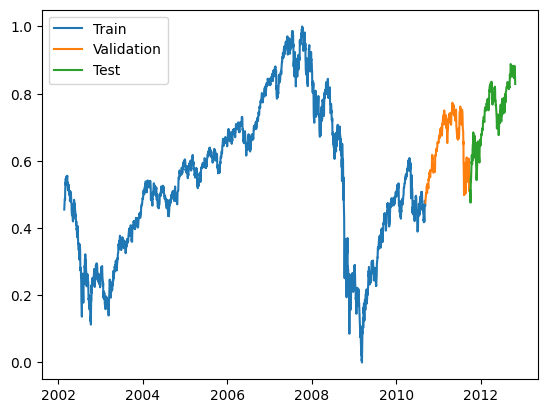

In [463]:

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

 **GRIDSEARCH and KERAS Classifier To find the optimum number of hidden layers**

In [464]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, Activation
from keras.activations import relu,sigmoid

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [465]:
def create_model(layers,activation):
  m=Sequential()
  for i,nodes in enumerate(layers):
    if i==0:
      m.add(Dense(nodes,input_dim=X_train.shape[1]))
      m.add(Activation(activation))
    else:
      m.add(Dense(nodes))
      m.add(Activation(activation))
    m.add(Dense(1))
    m.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return m

m=KerasClassifier(build_fn=create_model,verbose=0)


<ipython-input-465-0200c008dd00>:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  m=KerasClassifier(build_fn=create_model,verbose=0)


In [466]:
m

Gridsearch

In [467]:
layers=[[20],[40,20],[45,30,15],[64,32,16],[64,32]]
activitations=['sigmoid','relu']
param_grid=dict(layers=layers,activation=activitations,batch_size=[128,256],epochs=[30])
grid=GridSearchCV(estimator=m,param_grid=param_grid)

In [468]:
#grid_result=grid.fit(X_train,y_train)

In [469]:
#[grid_result.best_score_,grid_result.best_params_]

# TRAINING THE FIRST MODEL

In [470]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


model = Sequential([layers.Input((4, 1)),
                    layers.LSTM(40),
                    layers.Dense(20, activation='sigmoid'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30,batch_size=128)

Epoch 1/30
17/17 [==============================] - 4s 69ms/step - loss: 0.3080 - mean_absolute_error: 0.5097 - val_loss: 0.2037 - val_mean_absolute_error: 0.4456
Epoch 2/30
17/17 [==============================] - 0s 7ms/step - loss: 0.0803 - mean_absolute_error: 0.2321 - val_loss: 0.0135 - val_mean_absolute_error: 0.1024
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 0.0229 - mean_absolute_error: 0.1218 - val_loss: 0.0034 - val_mean_absolute_error: 0.0449
Epoch 4/30
17/17 [==============================] - 0s 8ms/step - loss: 0.0188 - mean_absolute_error: 0.1099 - val_loss: 0.0055 - val_mean_absolute_error: 0.0628
Epoch 5/30
17/17 [==============================] - 0s 8ms/step - loss: 0.0150 - mean_absolute_error: 0.0977 - val_loss: 0.0019 - val_mean_absolute_error: 0.0375
Epoch 6/30
17/17 [==============================] - 0s 8ms/step - loss: 0.0108 - mean_absolute_error: 0.0813 - val_loss: 0.0015 - val_mean_absolute_error: 0.0325
Epoch 7/30
17/17 [=========

68/68 [==============================] - 1s 3ms/step


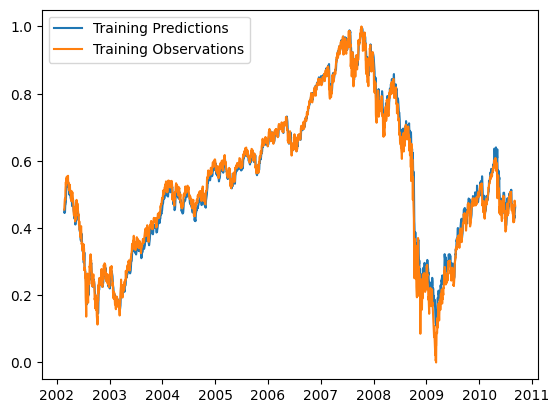

In [471]:
#predicting values for training data
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

9/9 [==============================] - 0s 6ms/step


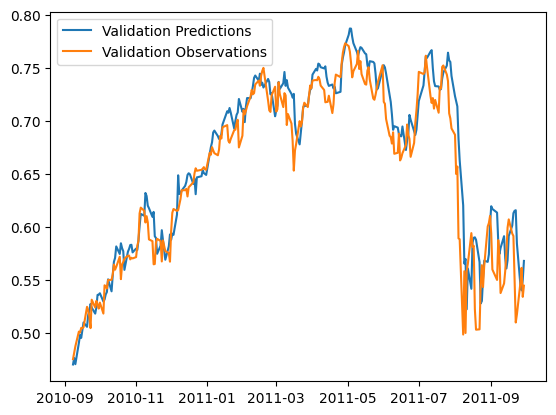

In [472]:
#predicting values for validation data
val_predictions = model.predict(X_val).flatten()
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

9/9 [==============================] - 0s 11ms/step


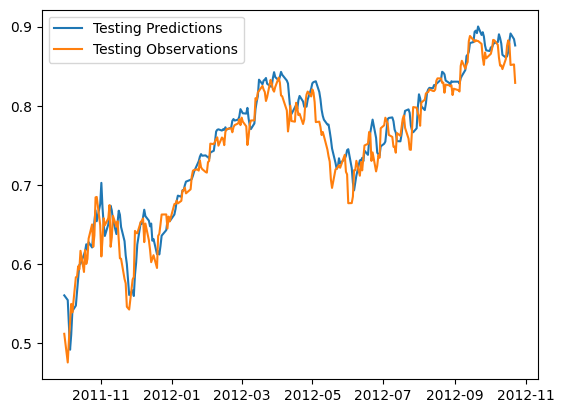

In [473]:
#prdeicting values for testing
test_predictions = model.predict(X_test).flatten()
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

**EVALUATION METRICS**

RMSE

In [474]:
import numpy as np
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(rmse)

0.023259124


MAE

In [475]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, test_predictions)
print(mae)

0.017564157


MSE

In [476]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, test_predictions)
print(mse)

0.00054098683


R2

In [477]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, test_predictions)
print(r2)

0.9305173133375237


MAPE

In [478]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, test_predictions)
print(mape)

2.493993192911148


The values of evaluation metrics may same perfect but our model have some fundamental issues as we have implemented the basic features using simplest of features

PREDICTING FUTURE VALUES

In [479]:
from copy import deepcopy
#test_predictions = model.predict(X_test).flatten()
recursive_predictions = []
#recursive_dates = np.concatenate([dates_val, dates_test])
recursive_dates = dates_val.copy()

last_window = deepcopy(X_train[-1])  # Start with the last window from the training set
#test_predictions = model.predict(X_test).flatten()
print(last_window)
for target_date in recursive_dates:
#    # Predict the next value based on the current window
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    print(next_prediction)

    last_window = np.roll(last_window, -1, axis=0)
    last_window[-1] = next_prediction


[[0.45436746]
 [0.46540698]
 [0.48162317]
 [0.24786219]]
1/1 [==============================] - 0s 99ms/step
[0.46150503]
1/1 [==============================] - 0s 35ms/step
[0.44525328]
1/1 [==============================] - 0s 33ms/step
[0.4198516]
1/1 [==============================] - 0s 37ms/step
[0.375195]
1/1 [==============================] - 0s 54ms/step
[0.4582687]
1/1 [==============================] - 0s 98ms/step
[0.44153726]
1/1 [==============================] - 0s 63ms/step
[0.43067926]
1/1 [==============================] - 0s 104ms/step
[0.43203628]
1/1 [==============================] - 0s 44ms/step
[0.46333754]
1/1 [==============================] - 0s 40ms/step
[0.45532325]
1/1 [==============================] - 0s 42ms/step
[0.45626307]
1/1 [==============================] - 0s 77ms/step
[0.46543932]
1/1 [==============================] - 0s 79ms/step
[0.47868067]
1/1 [==============================] - 0s 32ms/step
[0.47835982]
1/1 [==============================]

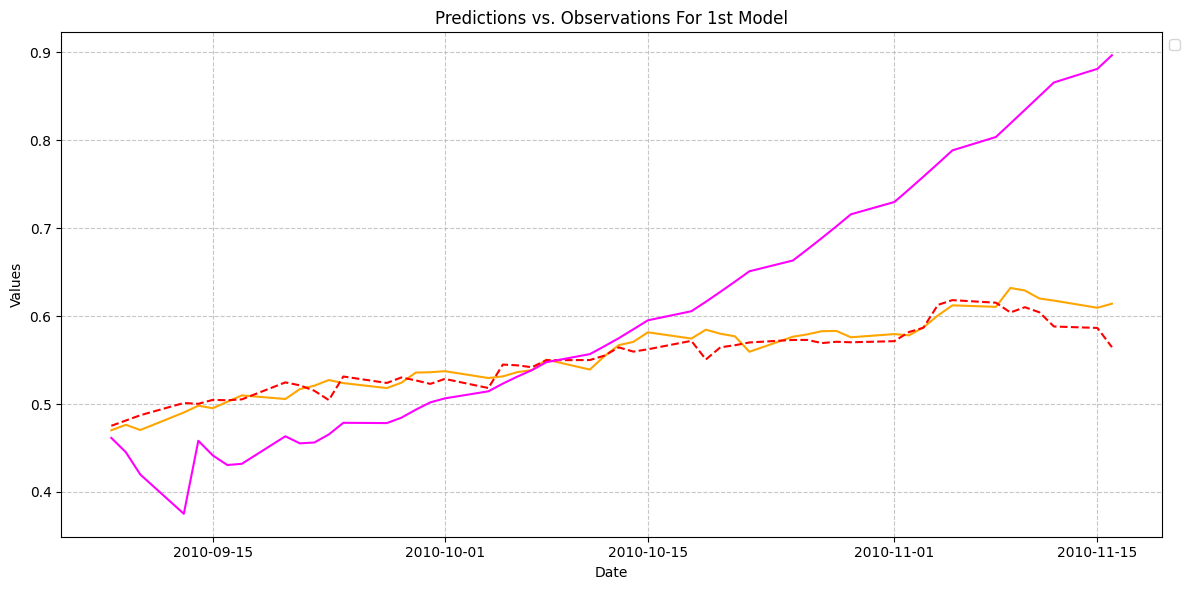

In [480]:
import matplotlib.pyplot as plt

# Define colors for each line
colors = {
    'Training Predictions': 'blue',
    'Training Observations': 'green',
    'Validation Predictions': 'orange',
    'Validation Observations': 'red',
    'Testing Predictions': 'purple',
    'Testing Observations': 'brown',
    'Recursive Predictions': 'magenta'
}

# Plot the data with labels and custom styles
plt.figure(figsize=(12, 6))  # Adjust the figure size

for label in colors.keys():
    plt.plot([], [], label=label, color=colors[label])  # Create empty lines for legend
n=50  #window size for prediction
# Plot the actual data

#plt.plot(dates_train, train_predictions, color=colors['Training Predictions'])
#plt.plot(dates_train, y_train, linestyle='--', color=colors['Training Observations'])
plt.plot(dates_val[:n], val_predictions[:n], color=colors['Validation Predictions'])
plt.plot(dates_val[:n], y_val[:n], linestyle='--', color=colors['Validation Observations'])
#plt.plot(dates_test, test_predictions, color=colors['Testing Predictions'])
#plt.plot(dates_test, y_test, linestyle='--', color=colors['Testing Observations'])
plt.plot(recursive_dates[:n], recursive_predictions[:n], color=colors['Recursive Predictions'])

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Predictions vs. Observations For 1st Model')

# Add a legend with a better layout
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Display grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Add data points to the legend for better identification
handles, labels = plt.gca().get_legend_handles_labels()
labels_and_handles = zip(labels, handles)
handles = [h[1] for h in sorted(labels_and_handles, key=lambda x: x[0])]
labels = [h[0] for h in sorted(labels_and_handles, key=lambda x: x[0])]
plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()  # Adjust spacing
plt.show()


# ***SECOND MODEL***



**NOW INTRODUCING NEW FEATURES FOR OUR MODEL**

In [481]:
#second_data=windowed_df.copy()
second_data = df_to_windowed_df(data, '2002-02-21', '2012-10-23', n=3)

second_data

,Target Date,Target-3,Target-2,Target-1,Volume,Target
0,2002-02-21,1104.180054,1083.339966,1097.979980,1.381600e+09,1080.949951
1,2002-02-22,1083.339966,1097.979980,1080.949951,1.411000e+09,1089.839966
2,2002-02-25,1097.979980,1080.949951,1089.839966,1.367400e+09,1109.430054
3,2002-02-26,1080.949951,1089.839966,1109.430054,1.309200e+09,1109.380005
4,2002-02-27,1089.839966,1109.430054,1109.380005,1.393800e+09,1109.890015
...,...,...,...,...,...,...
2685,2012-10-17,1428.589966,1440.130005,1454.920044,3.655320e+09,1460.910034
2686,2012-10-18,1440.130005,1454.920044,1460.910034,3.880030e+09,1457.339966
2687,2012-10-19,1454.920044,1460.910034,1457.339966,3.875170e+09,1433.189941
2688,2012-10-22,1460.910034,1457.339966,1433.189941,3.216220e+09,1433.819946


In [482]:
pip install ta

In [483]:
second_data

,Target Date,Target-3,Target-2,Target-1,Volume,Target
0,2002-02-21,1104.180054,1083.339966,1097.979980,1.381600e+09,1080.949951
1,2002-02-22,1083.339966,1097.979980,1080.949951,1.411000e+09,1089.839966
2,2002-02-25,1097.979980,1080.949951,1089.839966,1.367400e+09,1109.430054
3,2002-02-26,1080.949951,1089.839966,1109.430054,1.309200e+09,1109.380005
4,2002-02-27,1089.839966,1109.430054,1109.380005,1.393800e+09,1109.890015
...,...,...,...,...,...,...
2685,2012-10-17,1428.589966,1440.130005,1454.920044,3.655320e+09,1460.910034
2686,2012-10-18,1440.130005,1454.920044,1460.910034,3.880030e+09,1457.339966
2687,2012-10-19,1454.920044,1460.910034,1457.339966,3.875170e+09,1433.189941
2688,2012-10-22,1460.910034,1457.339966,1433.189941,3.216220e+09,1433.819946


In [484]:
#FEATURE ENGINEERING
import ta
print(second_data)
#1 . EMA
#second_data['EMA_8'] = second_data['Target'].ewm(span=8, adjust=False).mean()
#second_data['EMA_20'] = second_data['Target'].ewm(span=20, adjust=False).mean()
#second_data['EMA_50'] = second_data['Target'].ewm(span=50, adjust=False).mean()
#second_data['EMA_200'] = second_data['Target'].ewm(span=200, adjust=False).mean()

# A Moving Average is a trend-following indicator that smooths out price data over a specific period of time. It helps traders identify the overall direction of a price trend.
second_data['EMA_10'] = second_data['Target'].rolling(window=10).mean()  # 10-day moving average
second_data['EMA_20'] = second_data['Target'].rolling(window=20).mean()  # 20-day moving average
second_data['EMA_50'] = second_data['Target'].rolling(window=50).mean()  # 50-day moving average
second_data['EMA_200'] = second_data['Target'].rolling(window=200).mean()  # 200-day moving average


# 2. Volume Moving Average
#second_data['Volume_MA_10'] = second_data['Volume'].rolling(window=10).mean()  # 10-day volume moving average

# 3. RSI (Relative Strength Index)
#The RSI is a momentum oscillator that measures the speed and change of price movements. It helps traders identify overbought or oversold conditions in an asset.
second_data['RSI'] = ta.momentum.RSIIndicator(second_data['Target'], window=14).rsi()


 #MACD is a trend-following momentum indicator that shows the relationship between two moving averages of an asset's price. It helps traders identify potential trend reversals and the strength of a trend.
# 4. MACD (Moving Average Convergence Divergence)
macd = ta.trend.MACD(second_data['Target'])
second_data['MACD'] = ta.trend.macd_diff(second_data['Target'], window_slow=26, window_fast=12, window_sign=9)
second_data['MACD_Signal'] = ta.trend.macd_signal(second_data['Target'], window_slow=26, window_fast=12, window_sign=9)
#The MACD Signal Line, also known as the "signal line" or "trigger line," is a 9-period Exponential Moving Average (EMA) applied to the MACD line. It helps traders generate buy or sell signals based on the MACD indicator.
# Drop rows with NaN values created by lag features and moving averages
second_data = second_data.dropna()

# Display the DataFrame with new features
#second_data.head()

print(second_data)


     Target Date     Target-3     Target-2     Target-1        Volume  \
0     2002-02-21  1104.180054  1083.339966  1097.979980  1.381600e+09   
1     2002-02-22  1083.339966  1097.979980  1080.949951  1.411000e+09   
2     2002-02-25  1097.979980  1080.949951  1089.839966  1.367400e+09   
3     2002-02-26  1080.949951  1089.839966  1109.430054  1.309200e+09   
4     2002-02-27  1089.839966  1109.430054  1109.380005  1.393800e+09   
...          ...          ...          ...          ...           ...   
2685  2012-10-17  1428.589966  1440.130005  1454.920044  3.655320e+09   
2686  2012-10-18  1440.130005  1454.920044  1460.910034  3.880030e+09   
2687  2012-10-19  1454.920044  1460.910034  1457.339966  3.875170e+09   
2688  2012-10-22  1460.910034  1457.339966  1433.189941  3.216220e+09   
2689  2012-10-23  1457.339966  1433.189941  1433.819946  3.587670e+09   

           Target  
0     1080.949951  
1     1089.839966  
2     1109.430054  
3     1109.380005  
4     1109.890015  
...

In [485]:
second_data=second_data.reset_index(drop=True)
second_data['Close']=second_data['Target']
second_data=second_data.drop(['Target'],axis=1)
second_data.rename(columns={'Close': 'Target'}, inplace=True)
second_data

,Target Date,Target-3,Target-2,Target-1,Volume,EMA_10,EMA_20,EMA_50,EMA_200,RSI,MACD,MACD_Signal,Target
0,2002-12-04,936.309998,934.530029,920.750000,1.588900e+09,927.268005,912.335007,879.303605,980.554153,53.292773,-0.624056,12.527276,917.580017
1,2002-12-05,934.530029,920.750000,917.580017,1.250200e+09,926.508002,911.474506,880.641405,979.682153,49.398258,-2.127092,11.995503,906.549988
2,2002-12-06,920.750000,917.580017,906.549988,1.241100e+09,924.354999,911.953503,881.787004,978.794103,51.369106,-2.704538,11.319369,912.229980
3,2002-12-09,917.580017,906.549988,912.229980,1.320800e+09,920.500000,911.816504,883.079604,977.706953,44.692515,-4.318919,10.239639,892.000000
4,2002-12-10,906.549988,912.229980,892.000000,1.286600e+09,917.658002,913.229504,884.863004,976.682303,49.078926,-4.403200,9.138839,904.450012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2486,2012-10-17,1428.589966,1440.130005,1454.920044,3.655320e+09,1446.964014,1447.545007,1431.765203,1372.238651,60.309887,-0.990749,5.202619,1460.910034
2487,2012-10-18,1440.130005,1454.920044,1460.910034,3.880030e+09,1446.558008,1447.399005,1432.867602,1373.138850,58.054535,-0.360359,5.112529,1457.339966
2488,2012-10-19,1454.920044,1460.910034,1457.339966,3.875170e+09,1443.783997,1446.051001,1433.475400,1373.899500,45.625011,-1.534161,4.728989,1433.189941
2489,2012-10-22,1460.910034,1457.339966,1433.189941,3.216220e+09,1441.577991,1444.897497,1434.034399,1374.679549,45.950117,-2.192362,4.180898,1433.819946


Implementing LIME

In [486]:
#!pip install lime

In [487]:
#from lime import lime_tabular
#import numpy as np

In [488]:

#def model_predict(data):
#     return model.predict(data)

In [489]:
# Creating a LIME Explainer
#explainer = lime_tabular.LimeTabularExplainer(
#    training_data=np.array(X_train), # Replace with your training data
#    feature_names=['Target1', 'Target2', 'Target3'], # Replace with your feature names
#    mode='regression'
#)

In [490]:
# Reshape the test instance to match the input shape expected by the model
#test_instance = X_test[0].reshape(1, -1)  # Adjust the reshape parameters as per your model's requirement

# Generating explanation for the selected instance
#explanation = explainer.explain_instance(
#    data_row=test_instance,
#    predict_fn=model_predict
#)

# Displaying the explanation
#explanation.show_in_notebook(show_table=True)


In [491]:
#second_data = second_data.drop(["Target-1","Target-2","Target-3","EMA_8","EMA_20","EMA_50","EMA_200"], axis=1)
#second_data = second_data.drop(["Target-1","Target-2","Target-3","MA_10","MA_50"], axis=1)
second_data = second_data.drop(["Target-1","Target-2","Target-3"], axis=1)
fb_data=second_data.copy()

Scalling

In [492]:
second_data

,Target Date,Volume,EMA_10,EMA_20,EMA_50,EMA_200,RSI,MACD,MACD_Signal,Target
0,2002-12-04,1.588900e+09,927.268005,912.335007,879.303605,980.554153,53.292773,-0.624056,12.527276,917.580017
1,2002-12-05,1.250200e+09,926.508002,911.474506,880.641405,979.682153,49.398258,-2.127092,11.995503,906.549988
2,2002-12-06,1.241100e+09,924.354999,911.953503,881.787004,978.794103,51.369106,-2.704538,11.319369,912.229980
3,2002-12-09,1.320800e+09,920.500000,911.816504,883.079604,977.706953,44.692515,-4.318919,10.239639,892.000000
4,2002-12-10,1.286600e+09,917.658002,913.229504,884.863004,976.682303,49.078926,-4.403200,9.138839,904.450012
...,...,...,...,...,...,...,...,...,...,...
2486,2012-10-17,3.655320e+09,1446.964014,1447.545007,1431.765203,1372.238651,60.309887,-0.990749,5.202619,1460.910034
2487,2012-10-18,3.880030e+09,1446.558008,1447.399005,1432.867602,1373.138850,58.054535,-0.360359,5.112529,1457.339966
2488,2012-10-19,3.875170e+09,1443.783997,1446.051001,1433.475400,1373.899500,45.625011,-1.534161,4.728989,1433.189941
2489,2012-10-22,3.216220e+09,1441.577991,1444.897497,1434.034399,1374.679549,45.950117,-2.192362,4.180898,1433.819946


In [493]:
from sklearn.preprocessing import MinMaxScaler

# Assuming X_train1 is your training dataset and 'RSI' is the RSI feature
rsi_scaler = MinMaxScaler()
second_data['RSI'] = rsi_scaler.fit_transform(second_data[['RSI']])
second_data['MACD'] = rsi_scaler.fit_transform(second_data[['MACD']])
second_data['Volume'] = rsi_scaler.fit_transform(second_data[['MACD_Signal']])
second_data['Target'] = rsi_scaler.fit_transform(second_data[['Target']])
second_data['MACD_Signal'] = rsi_scaler.fit_transform(second_data[['MACD_Signal']])
second_data['EMA_10'] = rsi_scaler.fit_transform(second_data[['EMA_10']])
second_data['EMA_20'] = rsi_scaler.fit_transform(second_data[['EMA_20']])
second_data['EMA_50'] = rsi_scaler.fit_transform(second_data[['EMA_50']])
second_data['EMA_200'] = rsi_scaler.fit_transform(second_data[['EMA_200']])


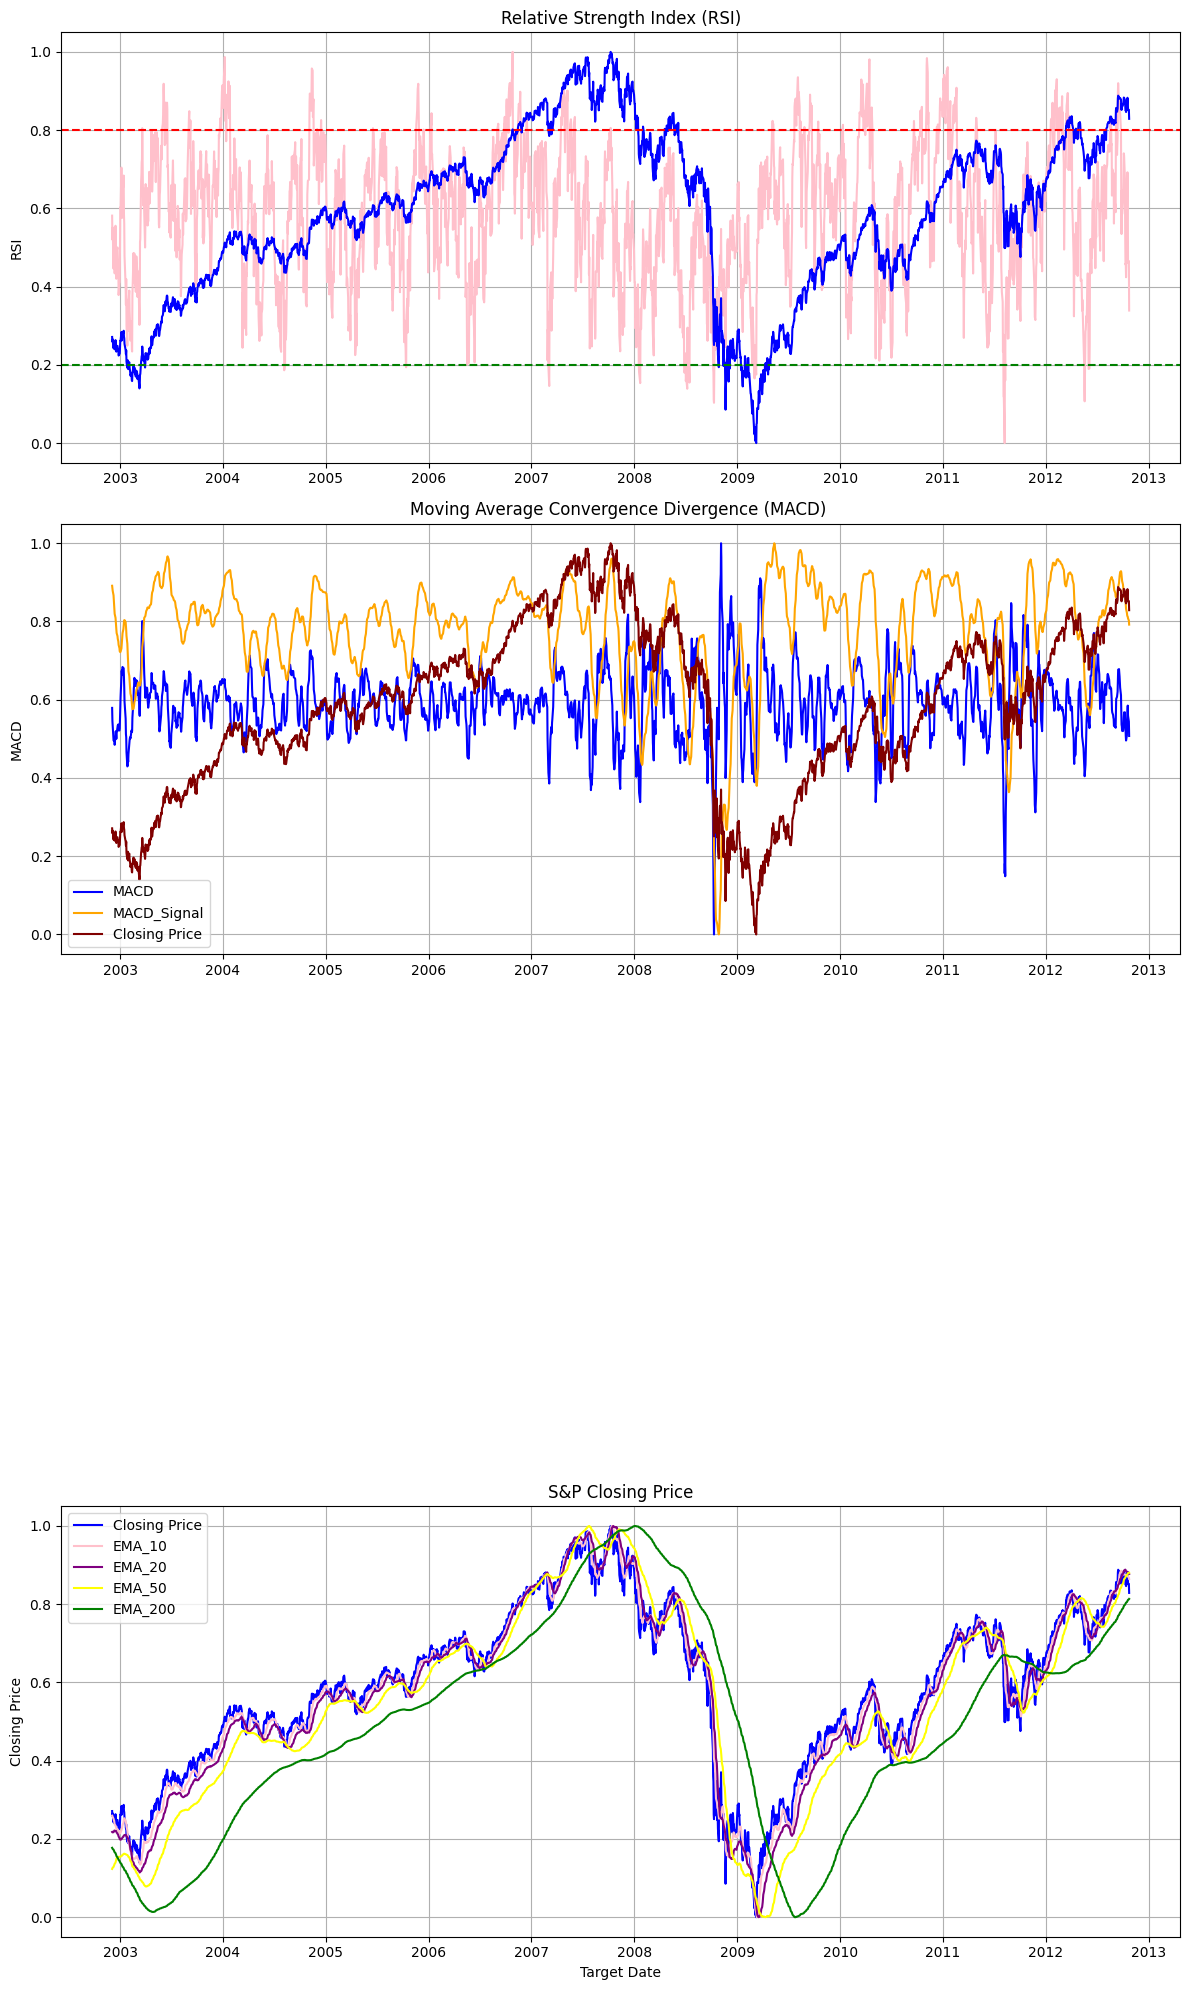

In [494]:
# Plotting the technical indicators for 2017-2018 data
plt.figure(figsize=(12, 20))

# RSI plot for 2017-2018
plt.subplot(4, 1, 1)
plt.plot(second_data['Target Date'], second_data['RSI'], color='pink')
plt.plot(second_data['Target Date'], second_data['Target'], label='Closing Price', color='blue')
plt.title('Relative Strength Index (RSI)')
plt.axhline(.80, color='r', linestyle='dashed')
plt.axhline(.20, color='g', linestyle='dashed')
plt.ylabel('RSI')
plt.grid(True)

# MACD plot for 2017-2018
plt.subplot(4, 1, 2)
plt.plot(second_data['Target Date'], second_data['MACD'], label='MACD', color='blue')
plt.plot(second_data['Target Date'], second_data['MACD_Signal'], label='MACD_Signal', color='orange')
plt.plot(second_data['Target Date'], second_data['Target'], label='Closing Price', color='maroon')
plt.title('Moving Average Convergence Divergence (MACD) ')
plt.ylabel('MACD')
plt.legend()
plt.grid(True)


# Closing Price plot for 2017-2018
plt.subplot(4, 1, 4)
plt.plot(second_data['Target Date'], second_data['Target'], label='Closing Price', color='blue')
plt.plot(second_data['Target Date'], second_data['EMA_10'], label='EMA_10', color='pink')
plt.plot(second_data['Target Date'], second_data['EMA_20'], label='EMA_20', color='purple')
plt.plot(second_data['Target Date'], second_data['EMA_50'], label='EMA_50', color='yellow')
plt.plot(second_data['Target Date'], second_data['EMA_200'], label='EMA_200', color='green')

plt.title('S&P Closing Price')
plt.xlabel('Target Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Correlation

<ipython-input-495-90b6d8f98a80>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = second_data.corr().loc[:, ['Target']]


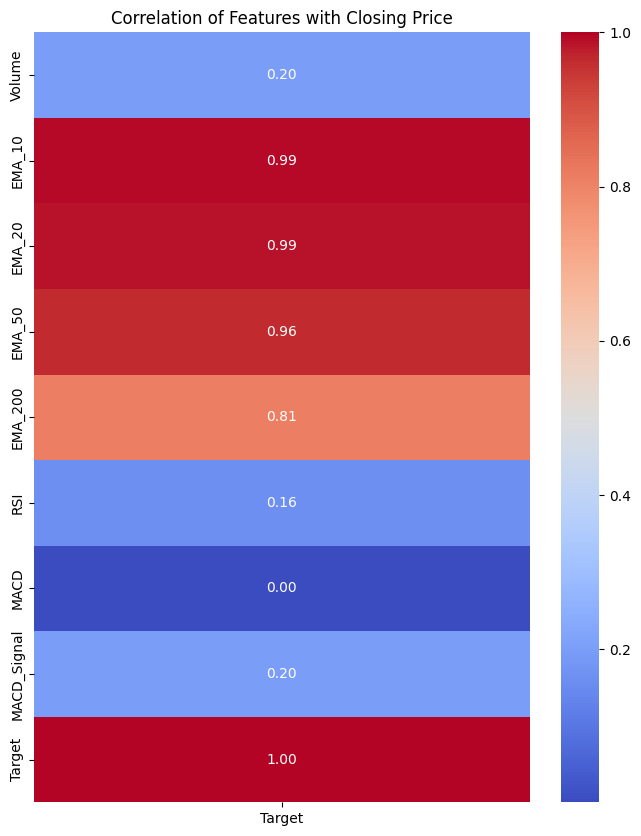

In [495]:
# Calculating the correlation matrix focusing on the correlation with 'Close'
correlation_matrix = second_data.corr().loc[:, ['Target']]
# Plotting the correlation heatmap
plt.figure(figsize=(8, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Features with Closing Price")
plt.show()

In [496]:
second_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2491 entries, 0 to 2490
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Target Date  2491 non-null   datetime64[ns]
 1   Volume       2491 non-null   float64       
 2   EMA_10       2491 non-null   float64       
 3   EMA_20       2491 non-null   float64       
 4   EMA_50       2491 non-null   float64       
 5   EMA_200      2491 non-null   float64       
 6   RSI          2491 non-null   float64       
 7   MACD         2491 non-null   float64       
 8   MACD_Signal  2491 non-null   float64       
 9   Target       2491 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 194.7 KB


Extracting "Date" , "Input" and "Output"

In [497]:
#second_data['Close']=second_data['Target']
#second_data=second_data.drop(['Target'],axis=1)
print(second_data)
second_data.rename(columns={'Close': 'Target'}, inplace=True)

# Convert the DataFrame to a NumPy array
df_as_np1 = second_data.to_numpy()



# Extract dates from the first column
dates1 = df_as_np1[:,0]



# Extract the feature matrix from columns 1 to second-to-last column
middle_matrix1 = df_as_np1[:, 1:-1]

# Reshape the feature matrix
X1 = middle_matrix1.reshape((len(dates1), middle_matrix1.shape[1], 1))

# Extract the target values from the last column
Y1 = df_as_np1[:, -1]

# Convert arrays to np.float32 data type

X1 = X1.astype(np.float32)
y1 = Y1.astype(np.float32)




# Print the shapes of the arrays
print("Dates shape:", dates1.shape)
print("X1 shape:", X1.shape)
print("Y1 shape:", y1.shape)



     Target Date    Volume    EMA_10    EMA_20    EMA_50   EMA_200       RSI  \
0     2002-12-04  0.891338  0.259498  0.217795  0.123273  0.177249  0.581432   
1     2002-12-05  0.885667  0.258599  0.216727  0.125098  0.175844  0.519958   
2     2002-12-06  0.878456  0.256052  0.217322  0.126662  0.174413  0.551067   
3     2002-12-09  0.866941  0.251491  0.217151  0.128425  0.172661  0.445679   
4     2002-12-10  0.855202  0.248129  0.218906  0.130859  0.171009  0.514917   
...          ...       ...       ...       ...       ...       ...       ...   
2486  2012-10-17  0.813224  0.874341  0.882510  0.877076  0.808498  0.692195   
2487  2012-10-18  0.812263  0.873861  0.882328  0.878580  0.809949  0.656595   
2488  2012-10-19  0.808172  0.870579  0.880654  0.879409  0.811175  0.460398   
2489  2012-10-22  0.802327  0.867969  0.879222  0.880172  0.812432  0.465530   
2490  2012-10-23  0.792063  0.864613  0.877453  0.880417  0.813499  0.338828   

          MACD  MACD_Signal    Target  

Using random forrest for feature evalutaion

In [498]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import numpy as np
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
y1_encoded = label_encoder.fit_transform(y1)


data = load_iris()
X = X1  # Features
y =y1_encoded  # Target labels


X = X.reshape(X.shape[0], -1)

# Create a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the entire dataset
model.fit(X, y)

# Get feature importances
feature_importances = model.feature_importances_

# Rank features by importance
sorted_indices = np.argsort(feature_importances)[::-1]

# Print feature rankings
print("Feature Rankings:")
for rank, idx in enumerate(sorted_indices):
    print(f"Rank {rank + 1}: Feature {idx} - Importance: {feature_importances[idx]}")

# Select the top k features (e.g., top 2 features)
k = 2
selected_features = sorted_indices[:k]

# Use the selected features for further analysis or modeling
X_selected = X[:, selected_features]


Feature Rankings:
Rank 1: Feature 4 - Importance: 0.12797824892455872
Rank 2: Feature 6 - Importance: 0.1261937404505499
Rank 3: Feature 5 - Importance: 0.12573499241549382
Rank 4: Feature 3 - Importance: 0.12494247847890466
Rank 5: Feature 2 - Importance: 0.12394391687827293
Rank 6: Feature 0 - Importance: 0.12379692251017872
Rank 7: Feature 7 - Importance: 0.12371979209604993
Rank 8: Feature 1 - Importance: 0.1236899082459913


Splitting

In [499]:
q_80 = int(len(dates1)* .85)
q_90 = int(len(dates1)* .9)

dates_train1, X_train1, y_train1 = dates1[:q_80],X1[:q_80],y1[:q_80]


dates_val1, X_val1, y_val1 = dates1[q_80:q_90],X1[q_80:q_90],y1[q_80:q_90]
dates_test1, X_test1, y_test1 = dates1[q_90:],X1[q_90:],y1[q_90:]

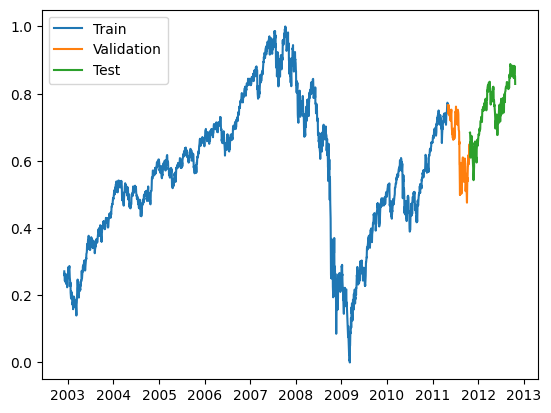

In [500]:

plt.plot(dates_train1, y_train1)
plt.plot(dates_val1, y_val1)
plt.plot(dates_test1, y_test1)

plt.legend(['Train', 'Validation', 'Test'])

GRIDSEARCH

In [501]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

In [502]:
def create_model1(layers,activation):
  model1=Sequential()
  for i,nodes in enumerate(layers):
    if i==0:
      model1.add(Dense(nodes,input_dim=X_train1.shape[1]))
      model1.add(Activation(activation))
    else:
      model1.add(Dense(nodes))
      model1.add(Activation(activation))
    model1.add(Dense(1))
    model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model1

model1=KerasClassifier(build_fn=create_model1,verbose=0)


<ipython-input-502-3a2713b38262>:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model1=KerasClassifier(build_fn=create_model1,verbose=0)


In [503]:
model1

In [504]:
layers=[[32],[40,20],[45,30,15],[64,32,32],[64,32],[20]]
activitations=['sigmoid','relu']
param_grid=dict(layers=layers,activation=activitations,batch_size=[128,256],epochs=[30])
grid1=GridSearchCV(estimator=model1,param_grid=param_grid)

In [505]:
#grid_result1=grid1.fit(X_train1,y_train1)

In [506]:
#[grid_result1.best_score_,grid_result1.best_params_]

TRAINING MODEL 2

In [507]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


model1 = Sequential([layers.Input((8, 1)),
                    layers.LSTM(64),

                    layers.Dense(40, activation='sigmoid'),
                    layers.Dense(20, activation='sigmoid'),


                    layers.Dense(1)])

model1.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=30, batch_size=128)

Epoch 1/30
17/17 [==============================] - 3s 48ms/step - loss: 0.0459 - mean_absolute_error: 0.1723 - val_loss: 0.0079 - val_mean_absolute_error: 0.0774
Epoch 2/30
17/17 [==============================] - 0s 16ms/step - loss: 0.0423 - mean_absolute_error: 0.1659 - val_loss: 0.0086 - val_mean_absolute_error: 0.0774
Epoch 3/30
17/17 [==============================] - 0s 15ms/step - loss: 0.0309 - mean_absolute_error: 0.1404 - val_loss: 0.0039 - val_mean_absolute_error: 0.0528
Epoch 4/30
17/17 [==============================] - 0s 16ms/step - loss: 0.0077 - mean_absolute_error: 0.0650 - val_loss: 0.0048 - val_mean_absolute_error: 0.0514
Epoch 5/30
17/17 [==============================] - 0s 16ms/step - loss: 0.0024 - mean_absolute_error: 0.0396 - val_loss: 0.0020 - val_mean_absolute_error: 0.0360
Epoch 6/30
17/17 [==============================] - 0s 15ms/step - loss: 0.0015 - mean_absolute_error: 0.0309 - val_loss: 0.0015 - val_mean_absolute_error: 0.0298
Epoch 7/30
17/17 [====

67/67 [==============================] - 2s 3ms/step


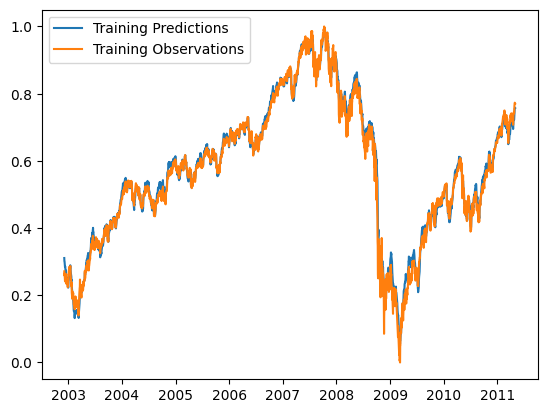

In [508]:
train_predictions1 = model1.predict(X_train1).flatten()

plt.plot(dates_train1, train_predictions1)
plt.plot(dates_train1, y_train1)
plt.legend(['Training Predictions', 'Training Observations'])

4/4 [==============================] - 0s 4ms/step


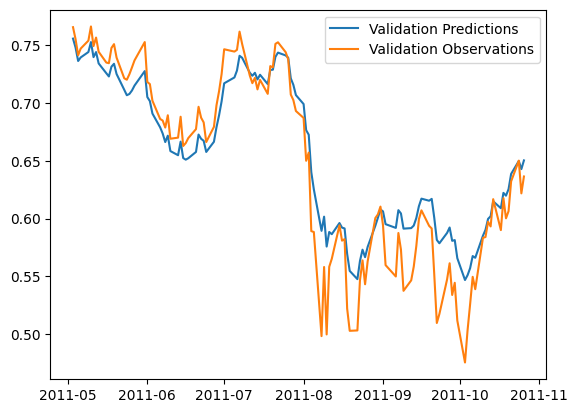

In [509]:
val_predictions1 = model1.predict(X_val1).flatten()

plt.plot(dates_val1, val_predictions1)
plt.plot(dates_val1, y_val1)
plt.legend(['Validation Predictions', 'Validation Observations'])

8/8 [==============================] - 0s 3ms/step


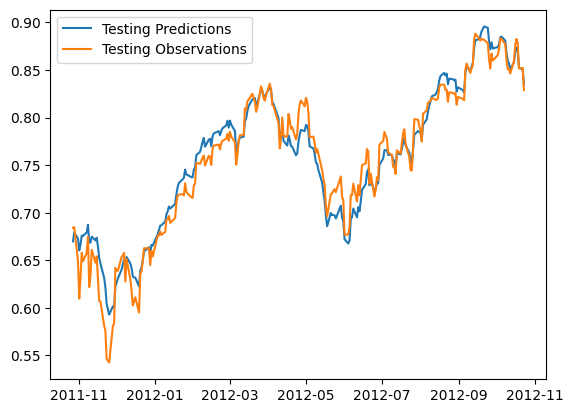

In [510]:
test_predictions1 = model1.predict(X_test1).flatten()

plt.plot(dates_test1, test_predictions1)
plt.plot(dates_test1, y_test1)
plt.legend(['Testing Predictions', 'Testing Observations'])

**EVALUATION METRICS**

RMSE

In [511]:
import numpy as np
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test1, test_predictions1))
print(rmse)

0.01677323


MAE

In [512]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test1, test_predictions1)
print(mae)

0.013288702


MSE

In [513]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test1, test_predictions1)
print(mse)

0.0002813412


R2

In [514]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test1, test_predictions1)
print(r2)

0.9533135411526826


MAPE

In [515]:
def mean_absolute_percentage_error(y_true, y_pred1):
    return np.mean(np.abs((y_true - y_pred1) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test1, test_predictions1)
print(mape)

1.856032945215702


The values of evaluation metrics may same perfect but our model have some fundamental issues as we have implemented the basic features using simplest of features

Prediction

In [516]:
from copy import deepcopy

recursive_predictions1 = []
recursive_dates1 = np.concatenate([dates_val1, dates_test1])

last_window1 = deepcopy(X_train1[-1])  # Start with the last window from the training set

for target_date in recursive_dates1:
    # Predict the next value based on the current window
    next_prediction1 = model1.predict(np.array([last_window1])).flatten()
    recursive_predictions1.append(next_prediction1)


    # Shift the window: drop the first element and append the new prediction
    last_window1 = np.roll(last_window1, -1, axis=0)
    last_window1[-1] = next_prediction1



1/1 [==============================] - 0s 22ms/step


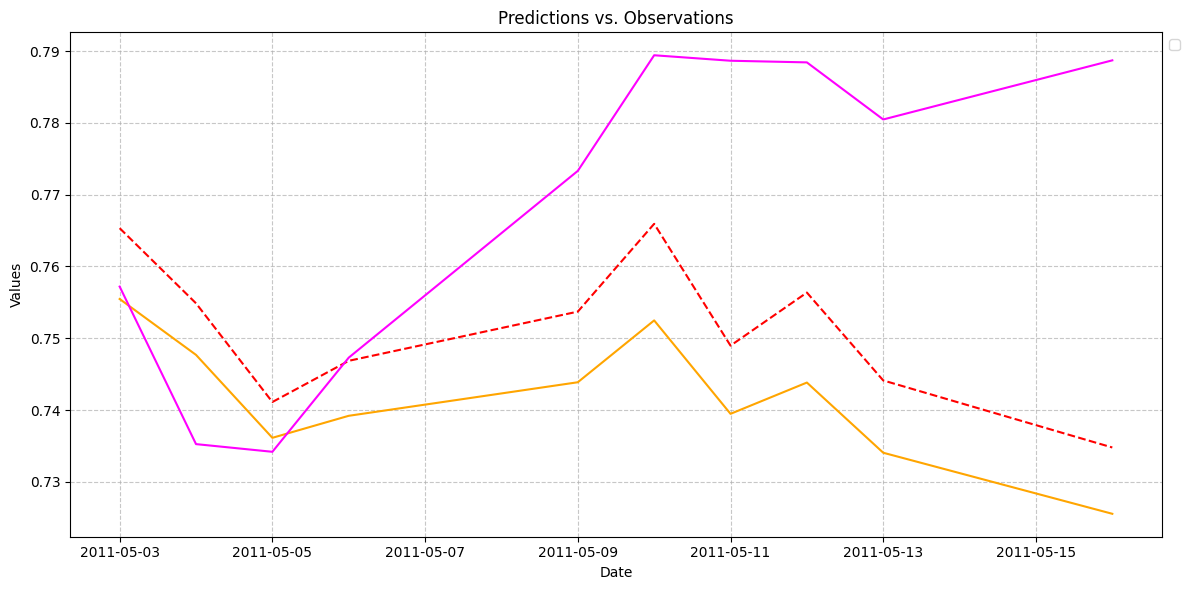

In [517]:
import matplotlib.pyplot as plt

# Define colors for each line
colors = {
    'Training Predictions': 'blue',
    'Training Observations': 'green',
    'Validation Predictions': 'orange',
    'Validation Observations': 'red',
    'Testing Predictions': 'purple',
    'Testing Observations': 'brown',
    'Recursive Predictions': 'magenta'
}

# Plot the data with labels and custom styles
plt.figure(figsize=(12, 6))  # Adjust the figure size

for label in colors.keys():
    plt.plot([], [], label=label, color=colors[label])  # Create empty lines for legend
n=10
# Plot the actual data
#plt.plot(dates_train1, train_predictions1, color=colors['Training Predictions'])
#plt.plot(dates_train1, y_train1, linestyle='--', color=colors['Training Observations'])
plt.plot(dates_val1[:n], val_predictions1[:n], color=colors['Validation Predictions'])
plt.plot(dates_val1[:n], y_val1[:n], linestyle='--', color=colors['Validation Observations'])
##plt.plot(dates_test1, test_predictions1, color=colors['Testing Predictions'])
#plt.plot(dates_test1, y_test1, linestyle='--', color=colors['Testing Observations'])
plt.plot(recursive_dates1[:n], recursive_predictions1[:n], color=colors['Recursive Predictions'])

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Predictions vs. Observations')

# Add a legend with a better layout
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Display grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Add data points to the legend for better identification
handles, labels = plt.gca().get_legend_handles_labels()
labels_and_handles = zip(labels, handles)
handles = [h[1] for h in sorted(labels_and_handles, key=lambda x: x[0])]
labels = [h[0] for h in sorted(labels_and_handles, key=lambda x: x[0])]
plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()  # Adjust spacing
plt.show()


 KFOLD

In [518]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential

layers = [64,20]  # Example: two hidden layers with 10 and 5 nodes
activation = 'sigmoid'  # Example activation function

# Define the KerasClassifier with these parameters
#model = KerasClassifier(build_fn=lambda: create_model(layers, activation), epochs=100, batch_size=10, verbose=0)

# Define the KerasClassifier with these parameters
#model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

# Define K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Specify the scoring metric (e.g., 'accuracy' for classification)
scoring_metric = 'accuracy'

# Perform K-Fold Cross-Validation with scoring
#results = cross_val_score(model1, X1, y1, cv=kfold, scoring=scoring_metric)

# Output the results
#print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# FB PROPHET

In [519]:
fb_data

,Target Date,Volume,EMA_10,EMA_20,EMA_50,EMA_200,RSI,MACD,MACD_Signal,Target
0,2002-12-04,1.588900e+09,927.268005,912.335007,879.303605,980.554153,53.292773,-0.624056,12.527276,917.580017
1,2002-12-05,1.250200e+09,926.508002,911.474506,880.641405,979.682153,49.398258,-2.127092,11.995503,906.549988
2,2002-12-06,1.241100e+09,924.354999,911.953503,881.787004,978.794103,51.369106,-2.704538,11.319369,912.229980
3,2002-12-09,1.320800e+09,920.500000,911.816504,883.079604,977.706953,44.692515,-4.318919,10.239639,892.000000
4,2002-12-10,1.286600e+09,917.658002,913.229504,884.863004,976.682303,49.078926,-4.403200,9.138839,904.450012
...,...,...,...,...,...,...,...,...,...,...
2486,2012-10-17,3.655320e+09,1446.964014,1447.545007,1431.765203,1372.238651,60.309887,-0.990749,5.202619,1460.910034
2487,2012-10-18,3.880030e+09,1446.558008,1447.399005,1432.867602,1373.138850,58.054535,-0.360359,5.112529,1457.339966
2488,2012-10-19,3.875170e+09,1443.783997,1446.051001,1433.475400,1373.899500,45.625011,-1.534161,4.728989,1433.189941
2489,2012-10-22,3.216220e+09,1441.577991,1444.897497,1434.034399,1374.679549,45.950117,-2.192362,4.180898,1433.819946


In [520]:
# Implementing Facebook Prophet for Time Series Forecasting
from prophet import Prophet


# Prepare the data for Prophet
df_prophet = fb_data.reset_index()[['Target Date', second_data.columns[-1]]]
# Include additional features in the original dataset
df_prophet.columns = ['ds', 'y']
#additional features
df_prophet['Volume'] = fb_data['Volume']
#df_prophet['EMA_10'] = fb_data['EMA_10']
#df_prophet['EMA_20'] = fb_data['EMA_20']
df_prophet['RSI'] = fb_data['RSI']
#df_prophet['EMA_50'] = fb_data['EMA_50']
df_prophet['EMA_200'] = fb_data['EMA_200']
df_prophet['Volume'] = fb_data['Volume']
df_prophet['MACD'] = fb_data['MACD']
df_prophet['MACD_Signal'] = fb_data['MACD_Signal']


model = Prophet()
model.add_regressor('Volume')
#model.add_regressor('EMA_10')
#model.add_regressor('EMA_20')
model.add_regressor('RSI')
#model.add_regressor('EMA_50')
#model.add_regressor('EMA_200')
model.add_regressor('MACD')
model.add_regressor('MACD_Signal')
model.fit(df_prophet)



# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=365)  # Adjust periods as needed

# Set constant future values for additional features
future['Volume'] = fb_data['Volume'].mean()  # Replace with an appropriate constant value
#future['EMA_10'] = fb_data['EMA_10'].mean()  # Replace with an appropriate constant value
#future['EMA_20'] = fb_data['EMA_20'].mean()  # Replace with an appropriate constant value
future['RSI'] = fb_data['RSI'].mean()  # Replace with an appropriate constant value
#future['EMA_50'] = fb_data['EMA_50'].mean()  # Replace with an appropriate constant value
future['EMA_200'] = fb_data['EMA_200'].mean()  # Replace with an appropriate constant value
future['MACD'] = fb_data['MACD'].mean()  # Replace with an appropriate constant value
future['MACD_Signal'] = fb_data['MACD_Signal'].mean()  # Replace with an appropriate constant value

forecast1 = model.predict(future)




INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6qx7zjd4/rq7ns4mx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6qx7zjd4/7_f5cbba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43107', 'data', 'file=/tmp/tmp6qx7zjd4/rq7ns4mx.json', 'init=/tmp/tmp6qx7zjd4/7_f5cbba.json', 'output', 'file=/tmp/tmp6qx7zjd4/prophet_modeljk63z5f0/prophet_model-20240123165824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:58:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:58:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


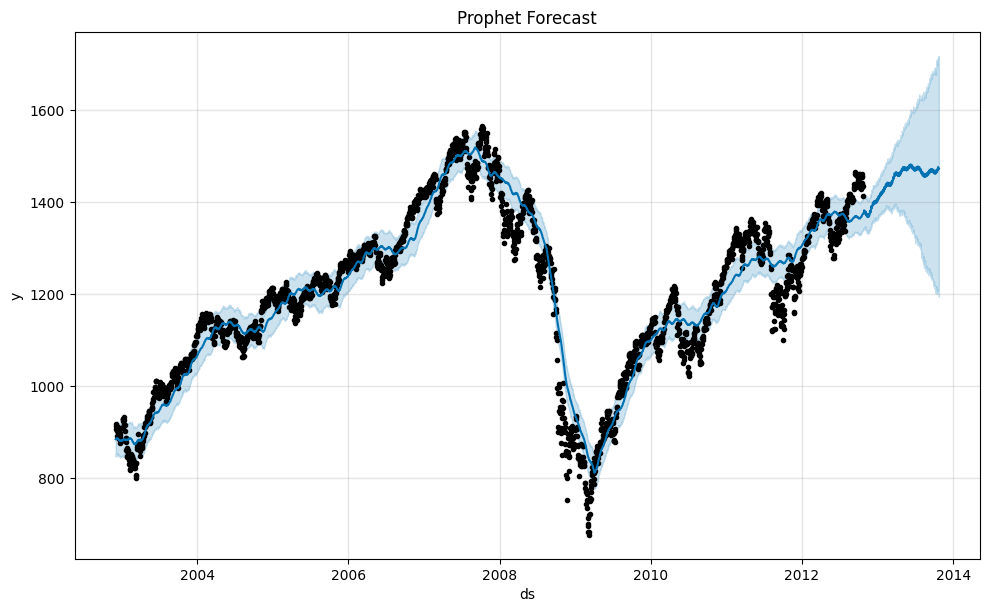

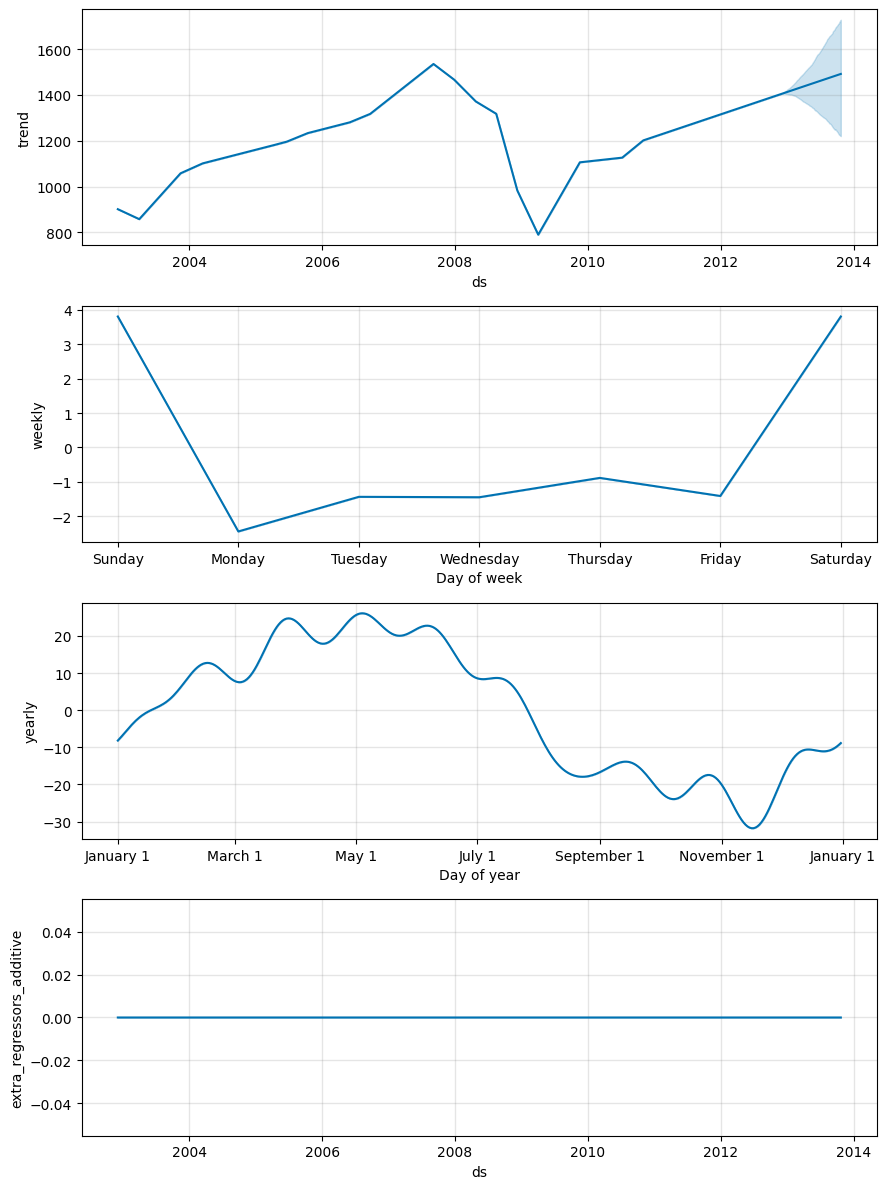

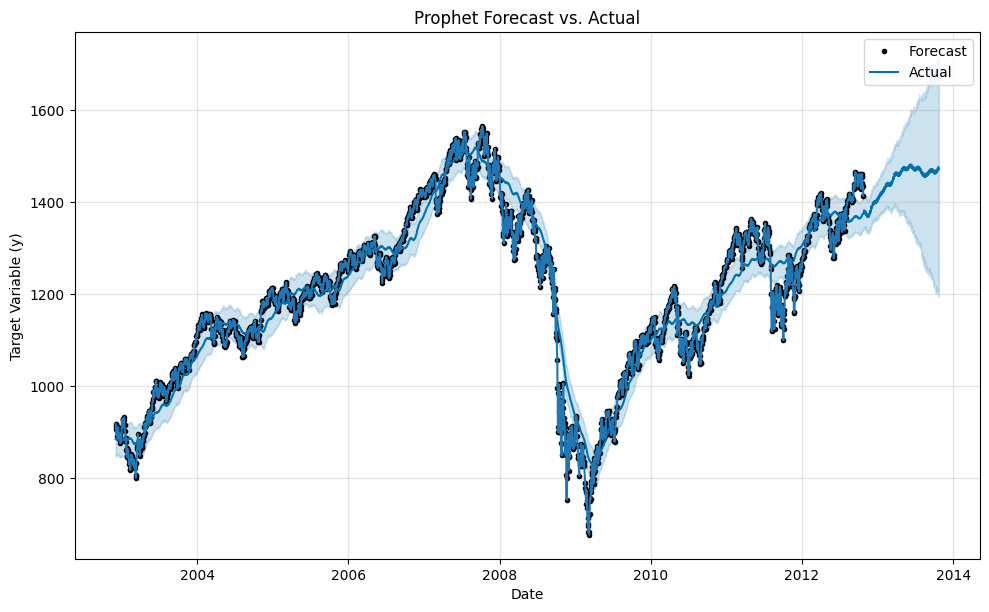

In [521]:

# Plotting the forecasts
import matplotlib.pyplot as plt

fig = model.plot(forecast1)
plt.title('Prophet Forecast')
plt.show()

# Plotting forecast components
fig2 = model.plot_components(forecast1)
plt.show()
import matplotlib.pyplot as plt

# Plotting the forecasts
fig = model.plot(forecast1)
plt.title('Prophet Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Target Variable (y)')

# Overlay the actual data on the plot
plt.plot(df_prophet['ds'], df_prophet['y'])
plt.legend(['Forecast', 'Actual'])

plt.show()

In [522]:

new_d['Date'] = pd.to_datetime(new_d['Date'], format='%Y-%m-%d')

# Filter rows for the specified date range
start_date = '2012-10-24'
end_date = '2013-10-24'

filtered_rows1 = new_d.loc[(new_d['Date'] >= start_date) & (new_d['Date'] <= end_date)].copy()

# Reset the index if needed
filtered_rows1.reset_index(drop=True, inplace=True)

# Display the filtered rows
print(filtered_rows1)


          Date         Open         High          Low        Close  \
0   2013-10-24  1747.479980  1753.939941  1745.500000  1752.069946   
1   2013-10-23  1752.270020  1752.270020  1740.500000  1746.380005   
2   2013-10-22  1746.479980  1759.329956  1746.479980  1754.670044   
3   2013-10-21  1745.199951  1747.790039  1740.670044  1744.660034   
4   2013-10-18  1736.719971  1745.310059  1735.739990  1744.500000   
..         ...          ...          ...          ...          ...   
246 2012-11-01  1412.199951  1428.349976  1412.199951  1427.589966   
247 2012-10-31  1410.989990  1418.760010  1405.949951  1412.160034   
248 2012-10-26  1412.969971  1417.089966  1403.280029  1411.939941   
249 2012-10-25  1409.739990  1421.119995  1405.140015  1412.969971   
250 2012-10-24  1413.199951  1420.040039  1407.099976  1408.750000   

         Volume    Adj Close  
0    3671700000  1752.069946  
1    3713380000  1746.380005  
2    3850840000  1754.670044  
3    3052710000  1744.660034  
4   

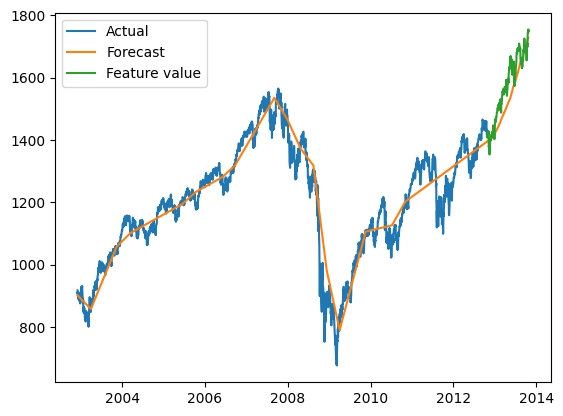

In [523]:

plt.plot(df_prophet['ds'], df_prophet['y'])
plt.plot(forecast1['ds'], forecast1['trend_upper'])
plt.plot(filtered_rows1['Date'], filtered_rows1['Close'])


plt.legend([ 'Actual','Forecast',"Feature value"])

plt.show()

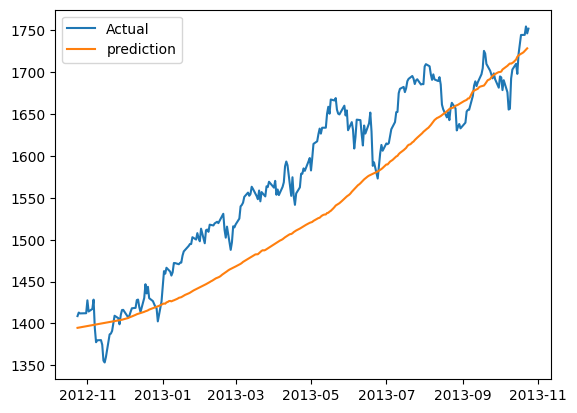

In [524]:
forecast1['ds'] = pd.to_datetime(forecast1['ds'], format='%Y-%m-%d')
# Filter rows for the specified date range

start_date = '2012-10-24'
end_date = '2013-10-24'
predicted = forecast1.loc[(forecast1['ds'] >= start_date) & (forecast1['ds'] <= end_date)].copy()

# Reset the index if needed
predicted.reset_index(drop=True, inplace=True)

plt.plot(filtered_rows1['Date'], filtered_rows1['Close'])

plt.plot(predicted['ds'], predicted['trend_upper'])
plt.legend([ 'Actual','prediction'])

plt.show()


In [525]:
forecast1

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,MACD,MACD_lower,MACD_upper,MACD_Signal,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2002-12-04,901.418418,846.401114,917.465523,901.418418,901.418418,0.0,0.0,0.0,0.0,...,-1.445661,-1.445661,-1.445661,-15.856877,-15.856877,-15.856877,0.0,0.0,0.0,884.115880
1,2002-12-05,901.048921,852.249150,921.467933,901.048921,901.048921,0.0,0.0,0.0,0.0,...,-0.883662,-0.883662,-0.883662,-14.868689,-14.868689,-14.868689,0.0,0.0,0.0,885.296570
2,2002-12-06,900.679424,851.961973,919.721852,900.679424,900.679424,0.0,0.0,0.0,0.0,...,-1.409167,-1.409167,-1.409167,-13.976837,-13.976837,-13.976837,0.0,0.0,0.0,885.293420
3,2002-12-09,899.570932,847.513043,918.914146,899.570932,899.570932,0.0,0.0,0.0,0.0,...,-2.440026,-2.440026,-2.440026,-11.938436,-11.938436,-11.938436,0.0,0.0,0.0,885.192470
4,2002-12-10,899.201435,852.578918,922.620908,899.201435,899.201435,0.0,0.0,0.0,0.0,...,-1.433920,-1.433920,-1.433920,-11.476702,-11.476702,-11.476702,0.0,0.0,0.0,886.290814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2851,2013-10-19,1490.869487,1206.322415,1714.212161,1223.470736,1722.868817,0.0,0.0,0.0,0.0,...,3.806222,3.806222,3.806222,-19.456229,-19.456229,-19.456229,0.0,0.0,0.0,1475.219480
2852,2013-10-20,1491.136615,1209.866978,1716.680594,1222.842792,1723.868559,0.0,0.0,0.0,0.0,...,3.806215,3.806215,3.806215,-18.938084,-18.938084,-18.938084,0.0,0.0,0.0,1476.004746
2853,2013-10-21,1491.403742,1202.679194,1713.607261,1222.221405,1725.428045,0.0,0.0,0.0,0.0,...,-2.440026,-2.440026,-2.440026,-18.472467,-18.472467,-18.472467,0.0,0.0,0.0,1470.491249
2854,2013-10-22,1491.670870,1210.296814,1717.356314,1221.565082,1726.987531,0.0,0.0,0.0,0.0,...,-1.433920,-1.433920,-1.433920,-18.075589,-18.075589,-18.075589,0.0,0.0,0.0,1472.161361
